In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_33/cc0pinp/0304/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 03062020


In [4]:
SHRCALIBFACTOR = 1.00

In [5]:
# USING BDT?
USEBDT = False

In [6]:
# Doing Run3?
ISRUN3 = True

In [7]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [8]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [9]:
tree = "NeutrinoSelectionFilter"

BNB = ""
EXT = ""
NU  = ""
NUE = ""
DRT = ""
NCPI0 = ""
CCPI0 = ""
CCNOPI = ""
CCCPI = ""
NCNOPI = ""
NCCPI = ""

if ISRUN3:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19'+ls.APPEND
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_all_reco2'+ls.APPEND
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2'+ls.APPEND
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'+ls.APPEND
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'+ls.APPEND
    NCPI0  = 'prodgenie_nc_pi0_uboone_overlay_mcc9.1_v08_00_00_26_run3_G_reco2'+ls.APPEND
    CCPI0  = 'prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run3_G_reco2'+ls.APPEND
    CCNOPI = 'prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_all_run3_reco2_reco2'+ls.APPEND
    CCCPI  = 'prodgenie_filter_CCmuCPiNoPi0_overlay_mcc9_v08_00_00_33_run3_reco2_reco2'+ls.APPEND
    NCNOPI = 'prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_new_run3_reco2_reco2'+ls.APPEND
    NCCPI  = 'prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_New_run3_reco2_reco2'+ls.APPEND
    
else:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19'+ls.APPEND
    #EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_C_all_reco2'+ls.APPEND
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_all_reco2'+ls.APPEND #Run1 + Run2
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2'+ls.APPEND
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'+ls.APPEND
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'+ls.APPEND
    NCPI0  = 'prodgenie_nc_pi0_uboone_overlay-v08_00_00_26_run1_reco2_reco2'+ls.APPEND
    CCPI0  = 'prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run1_reco2'+ls.APPEND
    CCNOPI = 'prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_all_run1_reco2_reco2'+ls.APPEND
    CCCPI  = 'prodgenie_filter_CCmuCPiNoPi0_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'+ls.APPEND
    NCNOPI = 'prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'+ls.APPEND
    NCCPI  = 'prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_run1_reco2_reco2'+ls.APPEND

mc = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]
ncpi0 = uproot.open(ls.ntuple_path+NCPI0+".root")[ls.fold][tree]
ccpi0 = uproot.open(ls.ntuple_path+CCPI0+".root")[ls.fold][tree]
ccnopi = uproot.open(ls.ntuple_path+CCNOPI+".root")[ls.fold][tree]
cccpi = uproot.open(ls.ntuple_path+CCCPI+".root")[ls.fold][tree]
ncnopi = uproot.open(ls.ntuple_path+NCNOPI+".root")[ls.fold][tree]
nccpi = uproot.open(ls.ntuple_path+NCCPI+".root")[ls.fold][tree]
nue = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
lee = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

uproot_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    #"pi0_energy2_Y", # pi0 tagger variables
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V"
]
#make the list unique
variables = list(set(variables))
print(variables)

if not ISRUN3:
    variables.remove("_closestNuCosmicDist")
    variables.remove("crtveto")
    variables.remove("crthitpe")
    
WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune"]#, "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]
SYSTEMATICS = ['weightsFlux','weightsGenie']

nue = nue.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
mc = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS, flatten=False)
ncpi0 = ncpi0.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
ccpi0 = ccpi0.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
ccnopi = ccnopi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
cccpi = cccpi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
ncnopi = ncnopi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
nccpi = nccpi.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)
lee = lee.pandas.df(variables + WEIGHTSLEE + SYSTEMATICS, flatten=False)

['mc_pdg', 'evnunhits', 'shrsubclusters0', 'run', 'p', 'npion', 'reco_nu_vtx_y', 'shr_tkfit_gap10_dedx_V', 'n_showers_contained', 'pion_e', 'shr_dedx_Y_cali', 'contained_fraction', 'matched_E', 'tksh_distance', '_closestNuCosmicDist', 'shrclusdir2', 'nu_e', 'shr_tkfit_gap10_nhits_Y', 'secondshower_Y_nhit', 'muon_e', 'slpdg', 'shr_tkfit_npoints', 'shrclusfrac0', 'shrmoliereavg', 'tksh_angle', 'trkshrhitdist2', 'interaction', 'shrsubclusters1', 'shr_tkfit_dedx_Y', 'pi0truth_elec_etot', 'category', 'trk_llr_pid_score_v', 'npi0', 'shr_tkfit_2cm_nhits_U', 'shr_phi', 'shr_tkfit_nhits_Y', 'selected', 'reco_nu_vtx_x', '_opfilter_pe_beam', 'CosmicDirAll3D', 'trk_calo_energy_y_v', 'sub', 'slnhits', 'backtracked_pdg', 'shr_theta', 'n_tracks_contained', 'shr_distance', 'trk_len', 'trk_score_v', 'shr_bkt_E', 'hits_ratio', 'shr_tkfit_gap10_nhits_U', 'shr_tkfit_dedx_V', 'evt', 'nu_pdg', 'shr_tkfit_nhits_U', 'pt', 'shr_dedx_Y', 'trk_bkt_pdg', 'shrmoliererms', '_opfilter_pe_veto', 'reco_nu_vtx_sce_y', 

In [10]:
df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,dirt]

for i,df in enumerate(df_v):
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    #df['weightSpline']  = df['weightSpline']  * df['weightTune']
    #df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] = df['weightSpline'] * df['weightTune'] * 0.7 #scale down pi0s

In [11]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
#df_v = [lee,mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['protonenergy'] = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['FMdiffOBV'] = df['nu_flashmatch_score']-df['best_obviouscosmic_flashmatch_score']
    #df['FMdiff'] = df['nu_flashmatch_score']-df['best_cosmic_flashmatch_score']

In [12]:
df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_dedx_avg'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']

In [13]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

# test calibrating dedx on Y plane
#data["shr_tkfit_gap10_dedx_Y"] = data["shr_tkfit_gap10_dedx_Y"]*1.03
#ext["shr_tkfit_gap10_dedx_Y"] = ext["shr_tkfit_gap10_dedx_Y"]*1.03
#data["shr_tkfit_2cm_dedx_Y"] = data["shr_tkfit_2cm_dedx_Y"]*1.03
#ext["shr_tkfit_2cm_dedx_Y"] = ext["shr_tkfit_2cm_dedx_Y"]*1.03
#data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"]*1.03
#ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"]*1.03

In [14]:
# avoid double-counting of events out of FV in the NC/CC pi0 samples
# not needed anymore since we improved matching with filtered samples
#ncpi0 = ncpi0.query('category != 5')
#ccpi0 = ccpi0.query('category != 5')
#ccnopi = ccnopi.query('category != 5')
#nccpi = nccpi.query('category != 5')
#ncnopi = ncnopi.query('category != 5')

## avoid recycling unbiased ext events (i.e. selecting a slice with little nu content from these samples)
ccnopi = ccnopi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')
cccpi = cccpi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')
ncnopi = ncnopi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')
nccpi = nccpi.query('(nslice==0 | (slnunhits/slnhits)>0.1)')

# add back the cosmic category, for background only
df_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [15]:
lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
ncpi0["is_signal"] = ncpi0["category"] == 11
ccpi0["is_signal"] = ccpi0["category"] == 11
ccnopi["is_signal"] = ccnopi["category"] == 11
cccpi["is_signal"] = cccpi["category"] == 11
ncnopi["is_signal"] = ncnopi["category"] == 11
nccpi["is_signal"] = nccpi["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

if (USEBDT == True):
    train_ncpi0, ncpi0 = train_test_split(ncpi0, test_size=0.5, random_state=1990)
    train_ccpi0, ccpi0 = train_test_split(ccpi0, test_size=0.5, random_state=1990)
    #train_ccnopi, ccnopi = train_test_split(ccnopi, test_size=0.5, random_state=1990)
    #train_cccpi, cccpi = train_test_split(cccpi, test_size=0.5, random_state=1990)
    #train_ncnopi, ncnopi = train_test_split(ncnopi, test_size=0.5, random_state=1990)
    #train_nccpi, nccpi = train_test_split(nccpi, test_size=0.5, random_state=1990)
    train_mc, mc = train_test_split(mc, test_size=0.5, random_state=1990)
    train_nue, nue = train_test_split(nue, test_size=0.5, random_state=1990)
    train_lee, lee = train_test_split(lee, test_size=0.5, random_state=1990)
    train_ext, ext = train_test_split(ext, test_size=0.5, random_state=1990)

In [16]:
# variables to be trained on
TRAINVAR = [#"n_showers_contained",
            "shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_gap10_dedx_Y","shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V",
            "shr_tkfit_2cm_dedx_Y","shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V",
            "trkfit","trkpid",
            "subcluster","shrmoliereavg",#"shrmoliererms",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            #'secondshower_V_nhit','secondshower_V_vtxdist','secondshower_V_dot','anglediff_V',
            #'secondshower_U_nhit','secondshower_U_vtxdist','secondshower_U_dot','anglediff_U',
            #"pi0_radlen1","pi0_radlen2","pi0_dedx2_fit_Y",
            #"pi0_energy2_Y","pi0_mass_Y","pi0_gammadot",
           ]

In [17]:
LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    #for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_dec.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            lee[label+"_score"] = booster.predict(
                xgb.DMatrix(lee[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ncpi0[label+"_score"] = booster.predict(
                xgb.DMatrix(ncpi0[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ccpi0[label+"_score"] = booster.predict(
                xgb.DMatrix(ccpi0[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ccnopi[label+"_score"] = booster.predict(
                xgb.DMatrix(ccnopi[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            cccpi[label+"_score"] = booster.predict(
                xgb.DMatrix(cccpi[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ncnopi[label+"_score"] = booster.predict(
                xgb.DMatrix(ncnopi[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nccpi[label+"_score"] = booster.predict(
                xgb.DMatrix(nccpi[TRAINVAR]),
                ntree_limit=booster.best_iteration)


In [18]:
dfbdt_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]

In [19]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/david/Neutrinos/NUE/PELEE3/plotter.py'>

In [37]:
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    "ncpi0": ncpi0,
    "ccpi0": ccpi0,
    "ccnopi": ccnopi,
    "cccpi": cccpi,
    "ncnopi": ncnopi,
    "nccpi": nccpi,
    "lee": lee,
}

if ISRUN3:
    scaling = 101.0/0.763
else:
    scaling = 101.0/4.08
#scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#0218
if ISRUN3:
    weights = {
        "mc": 5.70e-3 * SPLIT * scaling,
        "nue": 1.21e-4 * SPLIT * scaling,
        "ext": 2.11e-2 * SPLIT * scaling,
        "dirt": 2.35e-2 * scaling,
        "lee": 1.21e-4 * SPLIT * scaling,
        "ncpi0": 3.33e-3 * SPLIT * scaling,
        "ccpi0": 1.18e-3 * SPLIT * scaling,
        "ccnopi": 1.71e-03 * SPLIT * scaling,
        "nccpi": 5.51e-04 * SPLIT * scaling,
        "ncnopi": 1.11e-03 * SPLIT * scaling,
        "cccpi": 1.44e-3 * SPLIT * scaling,
    }
    pot = 0.763e19*scaling
else:
    weights = {
        "mc": 3.12e-2 * SPLIT * scaling,
        "nue": 7.73e-4 * SPLIT * scaling,
        "ext": 1.40e-1 * SPLIT * scaling, #C+D+E : 4.83e-2 #C only: 1.40e-1
        "dirt": 1.26e-1 * scaling,
        "lee": 7.73e-4 * SPLIT * scaling,
        "ncpi0": 1.53e-2 * SPLIT * scaling,
        "ccpi0": 1.17e-2 * SPLIT * scaling,
        "ccnopi": 8.81e-03 * SPLIT * scaling,
        "nccpi": 4.56e-03 * SPLIT * scaling,
        "ncnopi": 1.12e-02 * SPLIT * scaling,
        "cccpi": 6.74e-3 * SPLIT * scaling,
    }
    pot = 4.08e19*scaling
    
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.7545216251638271, 'nue': 0.016017038007863697, 'ext': 2.7930537352555707, 'dirt': 3.110747051114024, 'lee': 0.016017038007863697, 'ncpi0': 0.44079947575360423, 'ccpi0': 0.15619921363040631, 'ccnopi': 0.2263564875491481, 'nccpi': 0.07293709043250328, 'ncnopi': 0.14693315858453476, 'cccpi': 0.1906159895150721}


In [ ]:
# muon selection
QUERY = 'nslice == 1'
#if ISRUN3: QUERY += ' and ((crtveto!=1) or (crthitpe < 100)) and (_closestNuCosmicDist > 20.)'
#QUERY += ' and trk_len > 20'
#QUERY += ' and topological_score > 0.06'
#QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
#QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
#QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
#QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'

print (QUERY)

In [83]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [84]:
PRESQ1eNp = PRESQ + ' and n_tracks_contained > 0 and trkpid < -0.02'

In [85]:
# loose box cuts
NPLCUTQ = PRESQ
NPLCUTQ += ' and n_tracks_contained > 0'
NPLCUTQ += ' and CosmicIPAll3D > 20.'
NPLCUTQ += ' and trkpid < 0.1'
NPLCUTQ += ' and hits_ratio > 0.5'
NPLCUTQ += ' and shr_score < 0.40'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and shr_tkfit_dedx_avg < 4.0'
NPLCUTQ += ' and tksh_angle > -0.9'

In [86]:
# tight box cuts
NPTCUTQ = NPLCUTQ
NPTCUTQ += ' and CosmicIPAll3D > 30.'
NPTCUTQ += ' and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98'
NPTCUTQ += ' and trkpid < -0.02'
NPTCUTQ += ' and hits_ratio > 0.65'
NPTCUTQ += ' and shr_score < 0.25'
NPTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 10'
NPTCUTQ += ' and subcluster > 7'
NPTCUTQ += ' and trkfit < 0.70'
NPTCUTQ += ' and n_showers_contained == 1'
NPTCUTQ += ' and tksh_distance < 4.0'
NPTCUTQ += ' and trkshrhitdist2 < 1.5'
NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_avg > 1.0 and shr_tkfit_dedx_avg < 4.0)'
NPTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
NPTCUTQ += ' and secondshower_Y_nhit < 30'
NPTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.70'

In [87]:
# OLD loose box cuts
OLCUTQ = PRESQ
OLCUTQ += ' and CosmicIP > 20.'
OLCUTQ += ' and trkpid < 0.1'
OLCUTQ += ' and hits_ratio > 0.5'
OLCUTQ += ' and shr_score < 0.30'
OLCUTQ += ' and n_showers_contained == 1'
OLCUTQ += ' and tksh_distance < 6.0'
OLCUTQ += ' and shr_tkfit_2cm_dedx_avg < 4.0'
OLCUTQ += ' and tksh_angle > -0.9'
# OLD tight box cuts
OTCUTQ = OLCUTQ
OTCUTQ += ' and tksh_distance < 3.5'
OTCUTQ += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
OTCUTQ += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
OTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.75'
OTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
OTCUTQ += ' and trkpid < -0.02'
OTCUTQ += ' and n_showers_contained == 1'
OTCUTQ += ' and shr_score < 0.275'
OTCUTQ += ' and hits_ratio > 0.60'
OTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
OTCUTQ += ' and (trkfit < 0.45 or subcluster > 6)'

In [88]:
# BDT cuts
BDTCQ = OLCUTQ
#BDTCQ += ' and pi0_score > 0.995 and nonpi0_score > 0.9984'
BDTCQ += ' and pi0_score > 0.9988 and nonpi0_score > 0.998'

In [89]:
# Define actual selection
QUERY = NPTCUTQ
# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [91]:
# create output files based on selection
uproot_v = [lee,mc,ncpi0,ccpi0,ccnopi,cccpi,ncnopi,nccpi,nue,ext,data,dirt]
fname_v = [NUE,NU,NCPI0,CCPI0,CCNOPI,CCCPI,NCNOPI,NCCPI,NUE,EXT,BNB,DRT]

NU_Q = "~(abs(nu_pdg) == 12 & ccnc == 0)"
NU_Q += " & ~(mcf_np0==1 & mcf_nmp==0 & mcf_nmm==0 & mcf_nem==0 & mcf_nep==0)"
NU_Q += " & ~(mcf_pass_ccpi0==1)"
NU_Q += " & ~(mcf_pass_ccnopi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"
NU_Q += " & ~(mcf_pass_ncnopi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"
NU_Q += " & ~(mcf_pass_cccpi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"
NU_Q += " & ~(mcf_pass_nccpi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"

for i,name in enumerate(fname_v):
    if (i == 0):
        continue # skip LEE event. This one will be done within SBNFit
        
    df = dfbdt_v[i]
    
    fout = open(ls.ntuple_path+name+'.txt','w')
    dfsel = df.query(QUERY)
    if (i == 1):
        dfsel = dfsel.query(NU_Q)
    print ('file %s has %i selected entries'%(name,dfsel.shape[0]))
    for i,row in dfsel.iterrows():
        run = row['run']
        sub = row['sub']
        evt = row['evt']
        fout.write('%i %i %i \n'%(run,sub,evt))
    fout.close()

file prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2_nuepresel has 1 selected entries
file prodgenie_nc_pi0_uboone_overlay_mcc9.1_v08_00_00_26_run3_G_reco2_nuepresel has 11 selected entries
file prodgenie_cc_pi0_uboone_overlay_v08_00_00_26_run3_G_reco2_nuepresel has 14 selected entries
file prodgenie_CCmuNoPi_overlay_mcc9_v08_00_00_33_all_run3_reco2_reco2_nuepresel has 8 selected entries
file prodgenie_filter_CCmuCPiNoPi0_overlay_mcc9_v08_00_00_33_run3_reco2_reco2_nuepresel has 4 selected entries
file prodgenie_ncnopi_overlay_mcc9_v08_00_00_33_new_run3_reco2_reco2_nuepresel has 3 selected entries
file prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_New_run3_reco2_reco2_nuepresel has 4 selected entries
file prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2_nuepresel has 2981 selected entries
file data_extbnb_mcc9.1_v08_00_00_25_reco2_all_reco2_nuepresel has 0 selected entries
file data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good

/home/david/Neutrinos/NUE/PELEE3/plotter.py:229: RuntimeWarning: invalid value encountered in double_scalars
  for i, k in enumerate(num)


Profile likelihood: 2.85 sigma @ 1.01e21 POT
s/sqrt(b): 3.63 sigma @ 1.01e21 POT


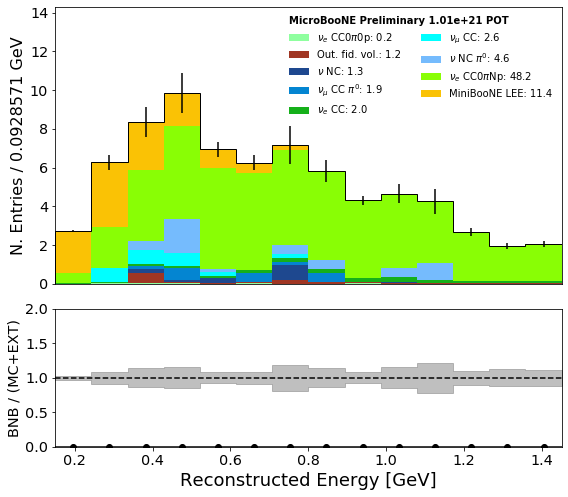

In [90]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

#QUERY += " & pi0truth_elec_etot<15 & npi0 == 0 & ccnc == 0"
#QUERY += " & muon_e>0.3 & npi0 == 0 & ccnc == 0"
#QUERY = "(muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category == 2"
#QUERY += " & ~((muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category != 5)"

VARIABLE, BINS, RANGE, XTIT = 'reco_e',14,(0.15,1.45),r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',20,(0,500),"pi0 mass Y"

#VARIABLE, BINS, RANGE, XTIT = 'muon_e',20,(0.,1.),r"Muon Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0truth_elec_etot',20,(0.,60),r"Michel Energy [GeV]"

#fig, ax1, ax2 = my_plotter.plot_variable(
fig, ax1 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,
    kind="event_category",
    #kind="sample",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=2,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:2]

print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,240)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
#ax2.set_ylim(0.5,1.5)
fig.savefig(ls.plots_path+VARIABLE+"_"+date_time+"_RUN3_1eNp.pdf")

In [ ]:
cccpi.query(QUERY)[["run","sub","evt","reco_e"]]

In [ ]:
mc.query(QUERY+"& ccnc==0 & nu_pdg==14 & mcf_np0==0")[["run","sub","evt","reco_e","mcf_lep_e","mcf_mcshr_elec_etot"]]

In [ ]:
QUERY += ' and reco_e > 0.15 and reco_e < 1.5'
#QUERY += ' and shr_tkfit_dedx_Y < 0'
plots = []
plots.append(['tksh_distance',20,(0,10),"tksh distance [cm]"])
#plots.append(['shr_tkfit_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 1-5 cm) [MeV/cm]"])
plots.append(['shr_tkfit_2cm_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_2cm_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 1-5 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 1-5 cm) [MeV/cm]"])
plots.append(['tksh_angle',20,(-1,1),"cos(tksh angle)"])
plots.append(['trkfit',20,(0,1),"Fraction of Track-fitted points"])
plots.append(['shrmoliereavg',20,(0,50),"average Moliere angle [degrees]"])
plots.append(['trkpid',15,(-1,1),"track LLR PID"])
plots.append(['n_showers_contained',10,(0,10),"n showers contained"])
plots.append(['n_tracks_contained',10,(0,10),"n tracks contained"])
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['trk_score',20,(0.5,1.0),"trk score"])
plots.append(['hits_ratio',20,(0,1),"shower hits/all hits"])
#plots.append(['slclustfrac',20,(0,1),"slice clustered fraction"])
#plots.append(['CosmicIP',20,(0,200),"Cosmic IP from vtx [cm]"])
#plots.append(['reco_nu_vtx_x',20,(0,260),"x"])
#plots.append(['reco_nu_vtx_y',20,(-120,120),"y"])
#plots.append(['reco_nu_vtx_z',20,(0,1100),"z"])
#plots.append(['reco_e_rqe',20,(0,2),"rqe"])
plots.append(['trkshrhitdist2',20,(0,10),"2D trk-shr distance (Y)"])
plots.append(['subcluster',20,(0,20),"N sub-clusters in shower"])
plots.append(['shrmoliererms',20,(0,5000),"RMS Moliere angle [degrees]"])
plots.append(['shr_energy_tot_cali',20,(0,1),"shr energy (calibrated) [GeV]"])
plots.append(['contained_fraction',20,(0.,1),"contained fraction"])
plots.append(['hits_y',20,(0.,1000),"N hits Y plane"])
#plots.append(['pi0_mass_Y',25,(-50.,200),"pi0 mass [Mev]"])
#plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])
plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
plots.append(['anglediff_Y',20,(0,350),"angle diff 1st-2nd shower (Y) [degrees]"])
plots.append(['secondshower_Y_vtxdist',20,(0.,200),"vtx dist 2nd shower (Y)"])
plots.append(['CosmicIPAll3D',20,(0,200),"CosmicIPAll3D [cm]"])
plots.append(['CosmicDirAll3D',20,(-1,1),"cos(CosmicDirAll3D)"])
#plots = []
#plots.append(['trkshrhitdist2',20,(0,10),"2D trk-shr distance (Y)"])
if USEBDT:
    plots = []
    plots.append(['pi0_score',20,(0.,1),"$\pi^0$ BDT response"])
    plots.append(['nonpi0_score',20,(0.,1),"non-$\pi^0$ BDT response"])
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    #ax1.set_ylim(0,ax1.get_ylim()[1]*1.4)
    #ax1.set_yscale("log")
    fig.show()
    #fig.savefig(ls.plots_path+"0109/run1/presel/"+VARIABLE+date_time+".pdf")

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.pyplot as plt

BINS = np.linspace(0,1,25)
VAR = 'cosmic_score'

nueplot = nue.query(QUERY)
nueplotecut = nueplot.query('nu_e < 0.8')

fig = plt.figure(figsize=(6,6))
plt.hist(nueplot[VAR].values,bins=BINS,histtype='step',lw=2,color='red',label='all nue')
plt.hist(nueplotecut[VAR].values,bins=BINS,histtype='step',lw=2,color='m',label='nue < 0.8 GeV')
#plt.hist(nue[VAR].values,bins=BINS,histtype='step',lw=2,color='green')
plt.grid()
plt.legend()
plt.title(VAR)
plt.show()

BINS2D = (np.linspace(0,3.0,25),BINS)

fig = plt.figure(figsize=(6,6))
plt.hist2d(nueplot['nu_e'].values,nueplot[VAR].values,bins=BINS2D)
#plt.hist(nue[VAR].values,bins=BINS,histtype='step',lw=2,color='green')
plt.grid()
plt.show()

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.pyplot as plt

x_range = (0.1,0.8)
n_bins = 7

n_tot = np.empty([50, n_bins])
n_cv_tot = np.empty(n_bins)
n_tot.fill(0)
n_cv_tot.fill(0)
score_cut = 0.997

my_cmap = cm.get_cmap('viridis')

for t in samples:
    if t in ["ext", "data", "lee"]:
        continue
    tree = samples[t]
    
    extra_query = ""
    if t == "mc":
        extra_query = "& ~(nu_pdg == 12 & ccnc == 0) & ~(npi0 != 0 & ccnc == 1)"
        
    queried_tree = tree.query("selected==1 & global_score > %g %s & interaction == 1" % (score_cut, extra_query))
    variable = queried_tree["reco_e"]
    genie_weights = queried_tree["weightsGenie"]
    spline_fix = queried_tree["weightSpline"]*weights[t]

    s = genie_weights
    df = pd.DataFrame(s.values.tolist())


    n_cv, bins = np.histogram(
        variable,
        range=x_range,
        bins=n_bins,
        weights=spline_fix)
    
    n_cv_tot += n_cv

    if not df.empty:
        for i in range(50):
            weight = df[i].values
            weight[np.isnan(weight)] = 1
            weight[weight > 100] = 1

            n, bins = np.histogram(
                variable, weights=weight*spline_fix, range=x_range, bins=n_bins)

            n_tot[i] += n

        
bincenters = 0.5 * (bins[1:] + bins[:-1])

left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([n_cv_tot,n_cv_tot]).T.flatten()
plt.plot(X,Y,color='r',linewidth=2,label='Central value')

    
cov = np.empty([len(n_cv), len(n_cv)])
cov.fill(0)

my_norm = Normalize(vmin=min((sum(n) for n in n_tot)), vmax=max((sum(n) for n in n_tot)))

for n in n_tot:
    left,right = bins[:-1],bins[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([n,n]).T.flatten()
    plt.plot(X,Y,color=my_cmap(my_norm(sum(n))),zorder=-32)
    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

cov /= 50
            
frac_cov = np.empty([len(n_cv), len(n_cv)])
corr = np.empty([len(n_cv), len(n_cv)])

for i in range(len(n_cv)):
    for j in range(len(n_cv)):
        frac_cov[i][j] = cov[i][j] / (n_cv_tot[i] * n_cv_tot[j])
        corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])

        
plt.errorbar(
    bincenters, 
    n_cv_tot,
    yerr=np.sqrt(np.diag(cov)), 
    fmt='none', 
    ecolor='r',
    linewidth=2,
    label='GENIE sys. uncertainties')

print(np.sqrt(np.diag(cov))/n_cv_tot)
plt.xlim(x_range[0], x_range[1])
plt.xlabel(r"$E_{deposited}$ [GeV]")
plt.legend()
plt.ylim(ymin=0)
plt.tight_layout()
plt.savefig("plots/spec.pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')
ax.set_title("Fractional covariance matrix")
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/frac.pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Correlation matrix")
pos = ax.imshow(corr, origin='lower', cmap='inferno')
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/corr.pdf", transparent=True)

In [ ]:
my_plotter.plot_2d(
    "global_score",
    "ncpi0_score",
    query="selected==1",
    bins_x=50,
    bins_y=50,
    range_x=(0., 1),
    range_y=(0., 1))